In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.metrics import r2_score

In [3]:
# Load dataset; adjust the path if necessary.
df = pd.read_csv("../data/Video_Timeseries.csv")


In [7]:
df = df.dropna()

In [8]:
# Use early engagement metrics as features.
features = ['views3s_1k',
       'impressions_1k', 'like_1k', 'comments_1k', 'views3s_5k',
       'impressions_5k', 'like_5k', 'comments_5k']
X = df[features].values
y = df['views_final'].values


In [9]:
# Fit an overall linear regression model.
lr_all = LinearRegression()
lr_all.fit(X, y)
y_pred = lr_all.predict(X)
print("Overall Linear Regression model R2:", r2_score(y, y_pred))


Overall Linear Regression model R2: 0.013006744604644127


In [19]:
# --- Clustering using original early engagement features ---
# Cluster videos based on the original features.
k = 4  # You can adjust the number of clusters as needed.
kmeans = KMeans(n_clusters=k, random_state=42)
df['cluster'] = kmeans.fit_predict(X)
print("\nCluster counts:")
print(df['cluster'].value_counts())


Cluster counts:
cluster
0    11341
2     1558
1      674
3      233
Name: count, dtype: int64


In [20]:
# Build a cluster-specific regression model for each cluster.
print("\nCluster-specific linear regression results:")
cluster_models = {}
for clust in range(k):
    df_cluster = df[df['cluster'] == clust]
    X_cluster = df_cluster[features].values
    y_cluster = df_cluster['views_final'].values

    model = LinearRegression()
    model.fit(X_cluster, y_cluster)
    y_cluster_pred = model.predict(X_cluster)
    r2_cluster = r2_score(y_cluster, y_cluster_pred)
    cluster_models[clust] = model
    print(f"Cluster {clust}: Samples = {len(df_cluster)}, R2 = {r2_cluster:.4f}")


Cluster-specific linear regression results:
Cluster 0: Samples = 11341, R2 = 0.0408
Cluster 1: Samples = 674, R2 = 0.0069
Cluster 2: Samples = 1558, R2 = 0.0368
Cluster 3: Samples = 233, R2 = 0.0707


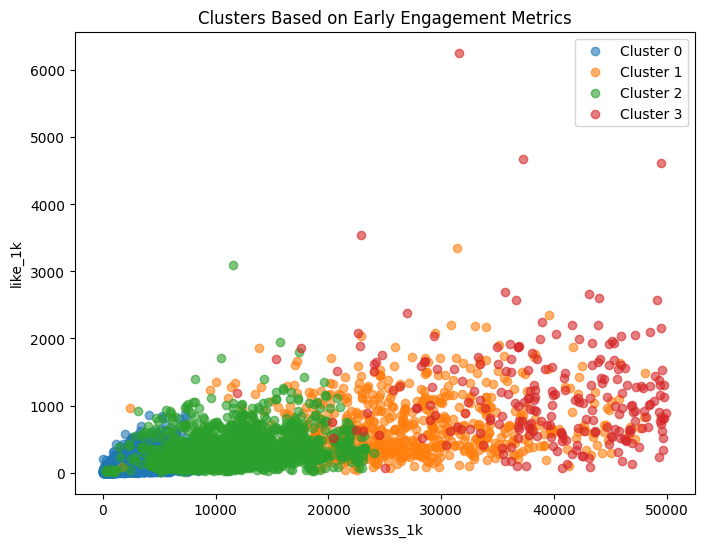

In [22]:
# Optional: Visualize clusters based on two selected features.
plt.figure(figsize=(8, 6))
for clust in range(k):
    subset = df[df['cluster'] == clust]
    plt.scatter(subset['views3s_1k'], subset['like_1k'], label=f'Cluster {clust}', alpha=0.6)
plt.xlabel('views3s_1k')
plt.ylabel('like_1k')
plt.title('Clusters Based on Early Engagement Metrics')
plt.legend()
plt.show()

Cluster counts based on predicted lifetime surrogate:
cluster
0    6044
2    4758
1    3004
Name: count, dtype: int64

Specialized Linear Regression Models (per cluster):
Cluster 0: N = 6044, R2 = 0.0103
Cluster 1: N = 3004, R2 = 0.0146
Cluster 2: N = 4758, R2 = 0.0062

Overall Linear Regression model R2 (no specialization): 0.0080


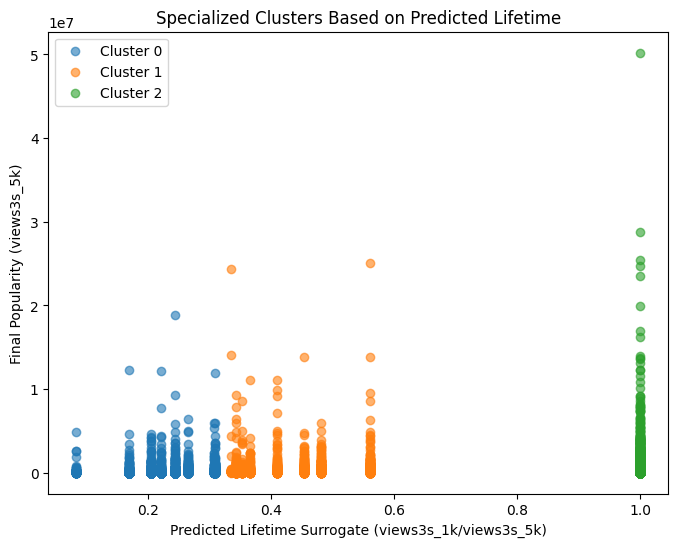

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn.cluster import KMeans
from sklearn.metrics import r2_score

# --- Step 1: Load Data ---
df = pd.read_csv("../data/Video_Timeseries.csv")

df = df.dropna()

# Use 'views3s_5k' as final popularity if 'views_final' is not provided.
if 'views_final' not in df.columns:
    df['views_final'] = df['views3s_5k']

# For our purposes, we focus on videos that have nonzero final views.
df = df[df['views3s_5k'] > 0].copy()

# --- Step 2: Compute Lifetime Surrogate ---
# As a proxy for the α-lifespan (with α=0.5), we use the fraction of final views achieved early.
# A higher fraction indicates that a video reached a large part of its final popularity quickly (i.e., a shorter lifetime).
df['lifetime_surrogate'] = df['views3s_1k'] / df['views3s_5k']

# --- Step 3: Predict Lifetime from Early Features ---
# In LARM the lifetime (α-lifespan) is predicted via early-accessible features.
# Here we use early engagement metrics as features.
early_features = ['views3s_1k', 'impressions_1k', 'like_1k', 'comments_1k']
X_lifetime = df[early_features].values
y_lifetime = df['lifetime_surrogate'].values

# Train a regression tree to predict the lifetime surrogate.
lifetime_model = DecisionTreeRegressor(random_state=42, max_depth=5)
lifetime_model.fit(X_lifetime, y_lifetime)
# Predict lifetime for each video (in a real scenario this would be used for fast prediction).
df['predicted_lifetime'] = lifetime_model.predict(X_lifetime)

# --- Step 4: Cluster Videos Based on Predicted Lifetime ---
# Following LARM, we cluster videos according to their (predicted) lifetime metric.
# Here we use K-means clustering on the 1D predicted lifetime feature.
k = 3  # You can adjust the number of specialized models (clusters) as needed.
X_cluster = df[['predicted_lifetime']].values
kmeans = KMeans(n_clusters=k, random_state=42)
df['cluster'] = kmeans.fit_predict(X_cluster)

# Optionally, sort clusters by the average predicted lifetime (shorter lifetime -> lower index)
cluster_order = df.groupby('cluster')['predicted_lifetime'].mean().sort_values().index.tolist()
mapping = {orig: new for new, orig in enumerate(cluster_order)}
df['cluster'] = df['cluster'].map(mapping)
print("Cluster counts based on predicted lifetime surrogate:")
print(df['cluster'].value_counts())

# --- Step 5: Build Specialized Regression Models ---
# For each cluster, train a linear regression model to predict final popularity (views_final)
# using the early engagement metrics.
print("\nSpecialized Linear Regression Models (per cluster):")
cluster_models = {}
for clust in range(k):
    df_clust = df[df['cluster'] == clust]
    X_cluster_model = df_clust[early_features].values
    y_cluster_target = df_clust['views_final'].values

    model = LinearRegression()
    model.fit(X_cluster_model, y_cluster_target)
    y_cluster_pred = model.predict(X_cluster_model)
    r2 = r2_score(y_cluster_target, y_cluster_pred)
    cluster_models[clust] = model
    print(f"Cluster {clust}: N = {len(df_clust):d}, R2 = {r2:.4f}")

# --- Step 6: Overall Model Evaluation ---
# For comparison, train a single (non-specialized) linear regression model.
X_all = df[early_features].values
y_all = df['views_final'].values
lr_all = LinearRegression()
lr_all.fit(X_all, y_all)
y_all_pred = lr_all.predict(X_all)
overall_r2 = r2_score(y_all, y_all_pred)
print(f"\nOverall Linear Regression model R2 (no specialization): {overall_r2:.4f}")

# --- Optional Visualization ---
plt.figure(figsize=(8, 6))
for clust in range(k):
    subset = df[df['cluster'] == clust]
    plt.scatter(subset['predicted_lifetime'], subset['views_final'], label=f'Cluster {clust}', alpha=0.6)
plt.xlabel("Predicted Lifetime Surrogate (views3s_1k/views3s_5k)")
plt.ylabel("Final Popularity (views3s_5k)")
plt.title("Specialized Clusters Based on Predicted Lifetime")
plt.legend()
plt.show()